# Mobile Game Analytics Project 🎮
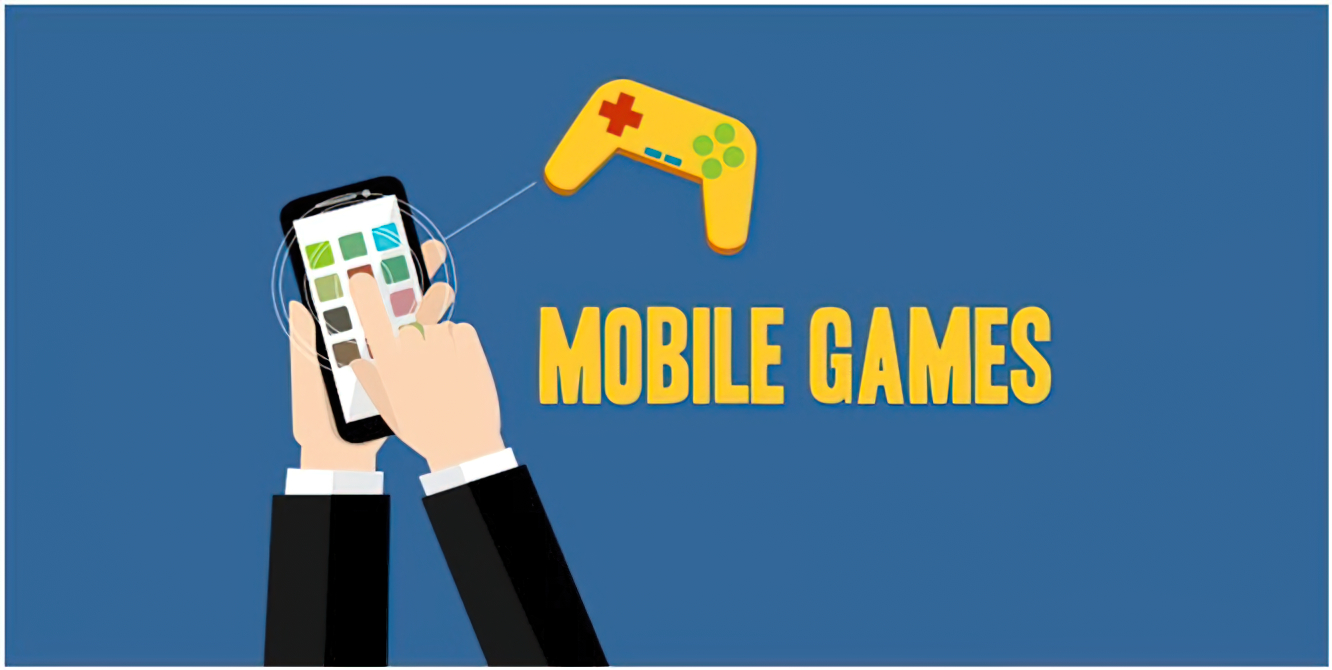
<br> Author: Raymond Peng 
<br> Contact Info: raymond.peng@mail.mcgill.ca
<br> Linkedin: www.linkedin.com/in/raymond-square-enix/

## Project Overview
Assume the persons who read this Jupyter Notebook are technical people. I will include a bit of technical jargons in the description below

<b>Stakeholder</b>:
   - Game designer

<b>Objectives</b>:
   - Identify potential paid users from new players who finished the onboarding tutorial
   - Apply data science techniques to suggest different prices & offers for those potential paid users
   
<b>Assumptions</b>:
   - The onboarding tutorial has <b>4 phrases</b> and each phrase allows players to enjoy a unique playstyle of the game
   - The experience points a player can accumulate from each phrase of the tutorial <b>is not fixed</b>. The amount depends on the performance and some optional activities during each phrase of tutorial
   - The experience points accumulated during tutorial can <b>reflect a user's engagement levels</b>
   - Experience points accumulated during each tutorial phrase will be tracked and recorded <b>at the completion</b> of that tutorial phrase
   - Metrics game_stats_xp, game_stats_xp1, game_stats_xp2, game_stats_xp3 represent the experience points a player accumulates in tutorial phrase0/1/2/3 correspondingly
   - All the stats_xp metrics mentioned above are <b>independent</b> from each other. They are not cumulative based on previous tutorial phrase but the exp points collected during the corresponding tutorial phrase
   - As last phrase of tutorial completed, the player need to collect some rewards and confirm to proceed to the main menu in order to complete the tutorial. <br>If he/she quit without collecting and proceeding, the tutorial will be considered as incomplete. 
   - All the user metrics under ka_devices and ka_users tables except for 'total_spend' will be <b>known and tracked</b> once a new user <b>opens the game for the first time</b>
   
<b>Solutions</b>:
   - Identify potential paid users from the new users who finished tutorial with a <b>classification model</b> based on features that are known by the end of tutorial
   - The classifcation model should focus on <b>recall ratio while keeping a good accuracy</b> since we want to identify as many actual paid users as possible
   - <b>Segment users who completed the tutorial</b> into different tiers based on their tutorial engagement levels which are reflected by <b>stats_xp variables</b> using <b>clustering</b>. Present the user behaviors under each tiers to game designers and discuss what prices or offers should be given correspondingly. <br>The cluster model can be used to label future new users to a tier
   - <b>Deploy the models</b> mentioned above into production after discussion with game desginer and the data science team (deployment process will not be included in this notebook)

<a name="0"></a> 
## Table of Content:
⏪ You can click on any of the section below to view it directly

- [1. Data Loading & Cleaning](#1)  
    - [1.1  Load ka_actions - user actions dataset](#1-1)
    - [1.2 Load ka_devices - user device info dataset](#1-2)
    - [1.3 Load ka_users - user info dataset](#1-3)
    - [1.4 Remove players who did not complete the tutorial¶](#1-4)
- [2. Exploratory Analysis](#2)  
    - [2.1 Spending Behaviour Investigation](#2-1)
    - [2.2 Explore how categorical user info relates to whether a user will spend or not](#2-2)
    - [2.3 Explore Player Action Columns Distribution](#2-3)
        - [2.3.1 Outliers Removal for Better Visualization & Comparison](#2-3-1)
    - [2.4 Comparison of Action Columns between Free & Paid User](#2-4)
        - [2.4.1 BarPlot Comparison of Action Columns between Free & Paid User](#2-4-1)
        - [2.4.2 BoxPlot Comparison of Action Columns between Free & Paid User](#2-4-2)
        - [2.4.3 Statistics Tests of Action Columns between Free & Paid User](#2-4-3)
    - [2.5 Explore relationship between total spend per user and action columns with scatter plot](#2-5)
    - [2.6 Correlation Exploration](#2-6)
- [3. Classification Model for Paid User Identification](#3)  
    - [3.1 Splitting the data](#3-1)
    - [3.2 Paid User Classification Model - Training & Evaluation](#3-2)
    - [3.3 Save paid user identification model for future deployment](#3-3)
- [4. Cluster Model to Segment Paid Users based on Engagement Level (XP Collected)](#4)  
    - [4.1 Unsupervised Clustering - Model Training & Evaluation](#4-1)
    - [4.2 Visualize Clusters with PCA & TSNE](#4-2)
    - [4.3 Compare exp_stats features between clusters](#4-3)
    - [4.4 Save segmentation model for deployment & predict cluster label for future new user](#4-4)  

<a name="1"></a> 
## 1. Data Loading & Cleaning
⏪ [Click here to go back to table of context](#0) 

In [1]:
import pandas as pd

<a name="1-1"></a> 
### 1.1 Load ka_actions - user actions dataset

In [119]:
ka_actions = pd.read_parquet('ka_actions.parquet', engine='pyarrow')

In [120]:
ka_actions.head()

,uid_s,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions
0,0,7.0,1.0,4.700000e+08,1693.0,592.0,0.0,429.0,446.0,364.0
1,1,2.0,1.0,6.120000e+08,197.0,197.0,0.0,0.0,60.0,125.0
2,2,2.0,1.0,3.900000e+08,313.0,313.0,0.0,0.0,89.0,129.0
3,3,3.0,1.0,6.610000e+08,1319.0,1319.0,0.0,0.0,275.0,200.0
4,4,4.0,1.0,3.147000e+09,148.0,148.0,0.0,0.0,58.0,138.0


In [121]:
ka_actions.game_stats_tutorial_complete.value_counts()

1.0    1751748
0.0       5249
Name: game_stats_tutorial_complete, dtype: int64

In [122]:
ka_actions.shape

(2845931, 10)

In [123]:
ka_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845931 entries, 0 to 2845930
Data columns (total 10 columns):
uid_s                                int64
logins                               float64
game_stats_tutorial_complete         float64
game_stats_tutorial_complete_time    float64
game_stats_xp                        float64
game_stats_xp1                       float64
game_stats_xp2                       float64
game_stats_xp3                       float64
redeemer_actions                     float64
scribe_actions                       float64
dtypes: float64(9), int64(1)
memory usage: 217.1 MB


In [124]:
ka_actions.isnull().sum()

uid_s                                      0
logins                                    37
game_stats_tutorial_complete         1088934
game_stats_tutorial_complete_time    1094183
game_stats_xp                         762888
game_stats_xp1                        762888
game_stats_xp2                        762888
game_stats_xp3                        762888
redeemer_actions                       10282
scribe_actions                             1
dtype: int64

 <a name="1-2"></a> 
 ### 1.2 Load ka_devices - user device info dataset

In [125]:
import sqlite3

In [126]:
cnx = sqlite3.connect('ka_devices.db')

ka_devices = pd.read_sql_query("SELECT * FROM devices", cnx)

In [127]:
ka_devices.head()

,index,uid_s,platform_s,device_mapped_s,device_manufacturer_s,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_height_i,device_gpu_s,device_os_s,device_model_s
0,0,0,android,asus_x01ad,asus,3575.0,1024.0,3584.0,1024.0,8.0,720.0,adreno (tm) 506,android os 9 / api-28 (ww_phone-201905061022/1...,asus_x01ad
1,1,1,android,moto g (5),motorola,1867.0,512.0,1920.0,512.0,8.0,1080.0,adreno (tm) 505,android os 8.1.0 / api-27 (opps28.85-13-6/04442),moto g (5)
2,2,2,android,mi 6,xiaomi,3726.0,1024.0,3776.0,1024.0,8.0,1080.0,adreno (tm) 540,android os 8.0.0 / api-26 (opr1.170623.027/v10...,mi 6
3,3,3,android,oppo r7splus,oppo,3629.0,1024.0,3648.0,1024.0,8.0,1080.0,adreno (tm) 405,android os 5.1.1 / api-22 (lmy47v/eng.root.201...,oppo r7splus
4,4,4,android,cph1803,oppo,2816.0,1024.0,2816.0,1024.0,8.0,720.0,adreno (tm) 506,android os 8.1.0 / api-27 (opm1.171019.026/155...,cph1803


In [128]:
ka_devices.drop(['index'],axis = 1,inplace = True)

In [129]:
ka_devices.shape

(2845931, 13)

In [130]:
len(pd.unique(ka_devices['uid_s']))

2845931

In [131]:
ka_devices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845931 entries, 0 to 2845930
Data columns (total 13 columns):
uid_s                     int64
platform_s                object
device_mapped_s           object
device_manufacturer_s     object
device_mem_i              float64
device_gmem_i             float64
device_mem_grouping_i     float64
device_gmem_grouping_i    float64
device_numcpu_i           float64
device_height_i           float64
device_gpu_s              object
device_os_s               object
device_model_s            object
dtypes: float64(6), int64(1), object(6)
memory usage: 282.3+ MB


In [132]:
ka_devices.isnull().sum()

uid_s                     0
platform_s                0
device_mapped_s           6
device_manufacturer_s     6
device_mem_i              1
device_gmem_i             1
device_mem_grouping_i     1
device_gmem_grouping_i    1
device_numcpu_i           1
device_height_i           1
device_gpu_s              1
device_os_s               1
device_model_s            6
dtype: int64

 <a name="1-3"></a> 
 ### 1.3 Load ka_users - user info dataset

In [133]:
ka_users = pd.read_csv('ka_users.csv')

In [134]:
ka_users.head()

,uid_s,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow,total_spend
0,0,EN,MY,asia,28800,14,3,0
1,1,ES,MX,americas,-18000,14,1,0
2,2,ZH-CN,CN,asia,28800,2,3,0
3,3,ZH-CN,CN,asia,28800,8,6,0
4,4,EN,IN,asia,19800,19,6,0


In [135]:
ka_users.shape

(2845931, 8)

In [136]:
ka_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845931 entries, 0 to 2845930
Data columns (total 8 columns):
uid_s                   int64
lang_s                  object
geo_s                   object
region_s                object
tz_i                    int64
local_time_join_hour    int64
local_time_join_dow     int64
total_spend             int64
dtypes: int64(5), object(3)
memory usage: 173.7+ MB


<a name="1-4"></a> 
### 1.4 Remove players who did not complete the tutorial
- The game designer only interested in new users who finished the tutorial
- Keep only the ones who completed and join with other 2 datasets with left join

In [137]:
ka_actions_completed_tutorial_users = ka_actions[ka_actions['game_stats_tutorial_complete']==1.0]

In [138]:
ka_actions_completed_tutorial_users.game_stats_tutorial_complete.value_counts()

1.0    1751748
Name: game_stats_tutorial_complete, dtype: int64

In [139]:
#Join all tables
actions_and_devices = ka_actions_completed_tutorial_users.merge(ka_devices,
               left_on='uid_s', right_on='uid_s', how='left')

In [140]:
final_df = actions_and_devices.merge(ka_users,
               left_on='uid_s', right_on='uid_s', how='left')

In [148]:
final_df.shape

(1751748, 30)

In [142]:
final_df.columns

Index(['uid_s', 'logins', 'game_stats_tutorial_complete',
       'game_stats_tutorial_complete_time', 'game_stats_xp', 'game_stats_xp1',
       'game_stats_xp2', 'game_stats_xp3', 'redeemer_actions',
       'scribe_actions', 'platform_s', 'device_mapped_s',
       'device_manufacturer_s', 'device_mem_i', 'device_gmem_i',
       'device_mem_grouping_i', 'device_gmem_grouping_i', 'device_numcpu_i',
       'device_height_i', 'device_gpu_s', 'device_os_s', 'device_model_s',
       'lang_s', 'geo_s', 'region_s', 'tz_i', 'local_time_join_hour',
       'local_time_join_dow', 'total_spend'],
      dtype='object')

In [26]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751748 entries, 0 to 1751747
Data columns (total 29 columns):
uid_s                                int64
logins                               float64
game_stats_tutorial_complete         float64
game_stats_tutorial_complete_time    float64
game_stats_xp                        float64
game_stats_xp1                       float64
game_stats_xp2                       float64
game_stats_xp3                       float64
redeemer_actions                     float64
scribe_actions                       float64
platform_s                           object
device_mapped_s                      object
device_manufacturer_s                object
device_mem_i                         float64
device_gmem_i                        float64
device_mem_grouping_i                float64
device_gmem_grouping_i               float64
device_numcpu_i                      float64
device_height_i                      float64
device_gpu_s                         

In [27]:
final_df.isnull().sum()

uid_s                                 0
logins                               12
game_stats_tutorial_complete          0
game_stats_tutorial_complete_time     0
game_stats_xp                        63
game_stats_xp1                       63
game_stats_xp2                       63
game_stats_xp3                       63
redeemer_actions                      0
scribe_actions                        0
platform_s                            0
device_mapped_s                       4
device_manufacturer_s                 2
device_mem_i                          1
device_gmem_i                         1
device_mem_grouping_i                 1
device_gmem_grouping_i                1
device_numcpu_i                       1
device_height_i                       1
device_gpu_s                          1
device_os_s                           1
device_model_s                        4
lang_s                                0
geo_s                                66
region_s                              0


In [143]:
final_df['spent_or_not'] = final_df['total_spend'] > 0

In [144]:
#pip install seaborn

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [100]:
import warnings
warnings.filterwarnings("ignore")

<a name="2"></a> 
## 2. Exploratory Analysis
⏪ [Click here to go back to table of context](#0)

<a name="2-1"></a> 
### 2.1 Spending Behaviour Investigation
- How many of them spent vs not spent?
- Among those who spent, what's the distribution of the amount they spent?

In [222]:
final_df['spent_or_not'].value_counts()

False    1721056
True       30692
Name: spent_or_not, dtype: int64

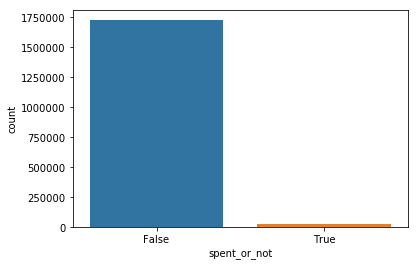

In [223]:
sns.countplot(x='spent_or_not',data=final_df)

Most users do not spend. Which fits the actual scenario in most mobile games

In [224]:
final_df['total_spend'].max()

450

(0, 500)

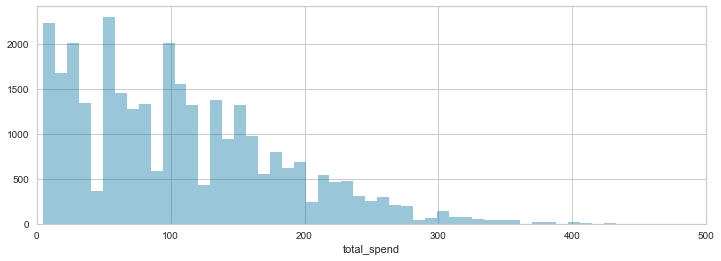

In [150]:
#Spend distribution on users who spent
plt.figure(figsize=(12,4))
sns.distplot(final_df[final_df['total_spend']!=0]['total_spend'],kde=False,bins=50)
plt.xlim(0,500)

<a name="2-2"></a> 
### 2.2 Explore how categorical user info relates to whether a user will spend or not
- For simplicity, I will call the one who spent as 'paid user' vs the one who doesn't as 'free user'

In [108]:
#!pip install plotly
import plotly.express as px

In [115]:
cate_columns_for_comparison_dict = {'platform_s': 'Platform','region_s': 'Region','geo_s': 'Country'
                                    ,'local_time_join_hour': 'Joined Hour(Local Time)','local_time_join_dow': 'Joined Day of Week(Local Time)'}

In [1]:
for col, col_meaning in cate_columns_for_comparison_dict.items(): 
    groupby = final_df.groupby([col,'spent_or_not']).size().reset_index()
    groupby['percentage'] = final_df.groupby([col,'spent_or_not']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).values
    groupby.columns = [col,'spent_or_not', 'number_of_users', 'Percentage']
    groupby.sort_values('number_of_users', ascending=False,inplace = True)

    fig = px.bar(groupby, x=col, y=['number_of_users'], color='spent_or_not', 
           text=groupby['Percentage'].apply(lambda x: '{0:1.2f}%'.format(x)),title="Number of Free vs Paid User per "+col_meaning)
    fig.update_layout(
        yaxis_title="number_of_users")
    fig.show()

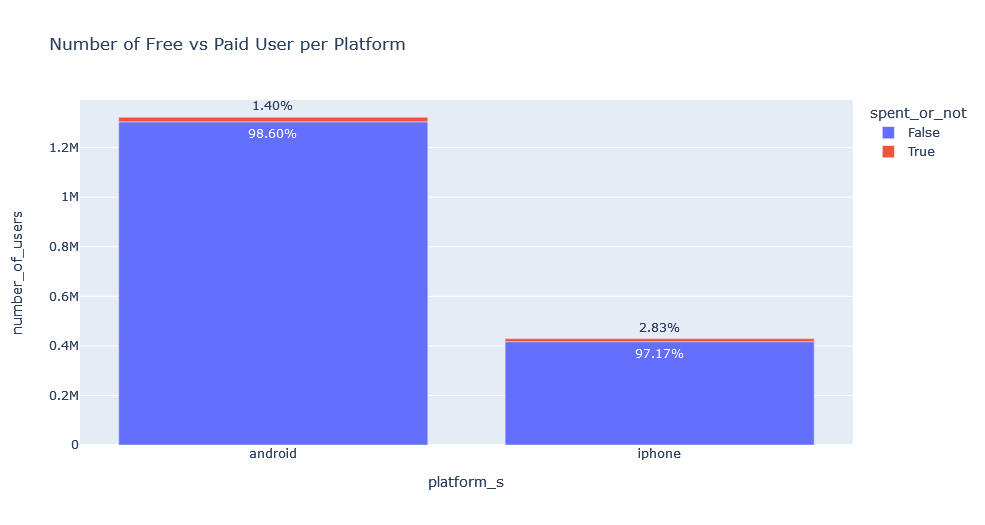

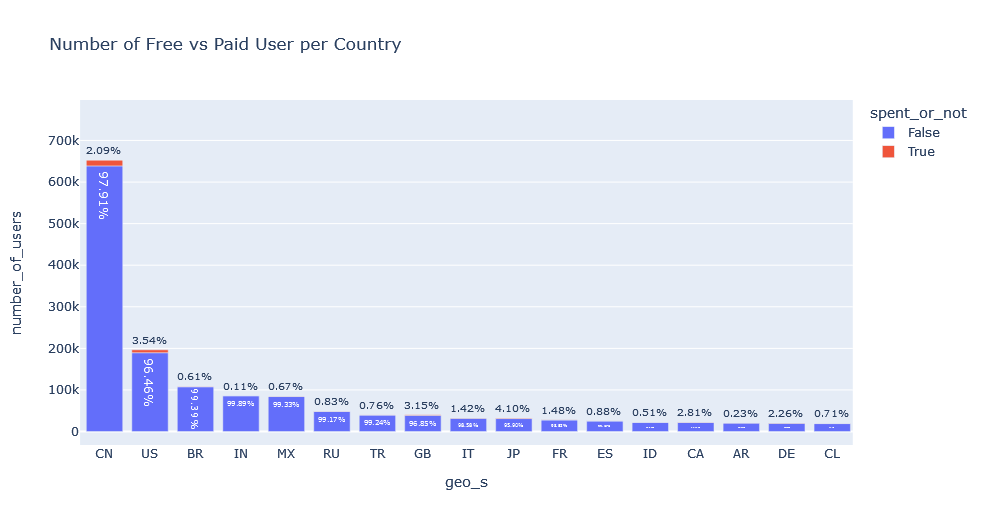

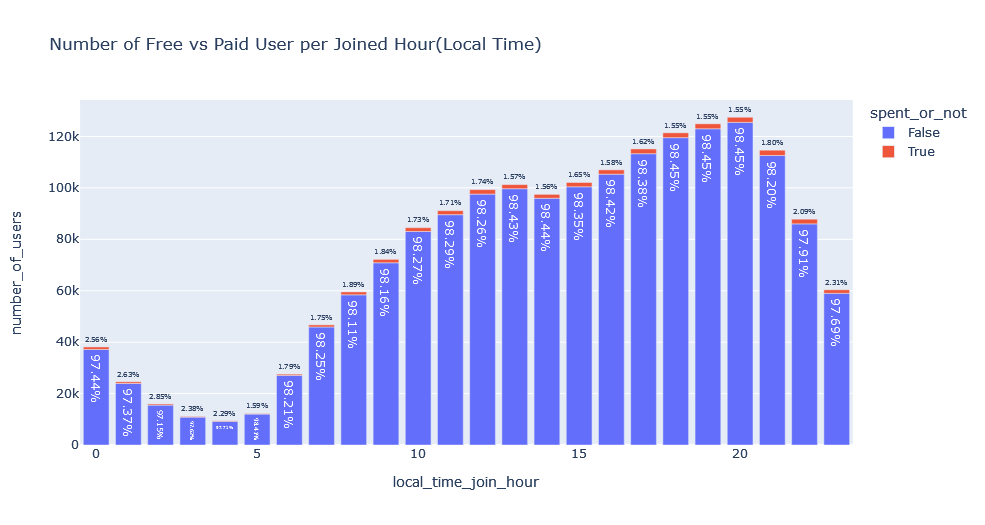

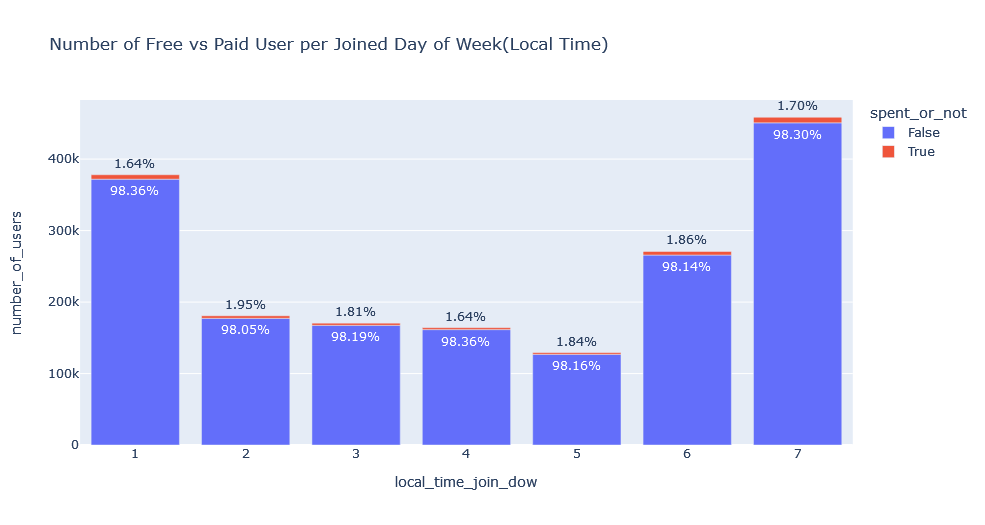

<a name="2-3"></a> 
### 2.3 Explore Player Action Columns Distribution 

In [153]:
action_cols = ['logins',
'game_stats_tutorial_complete_time',  
'game_stats_xp',                   
'game_stats_xp1',                    
'game_stats_xp2',                  
'game_stats_xp3',                  
'redeemer_actions',                  
'scribe_actions' ]

In [154]:
def dfdisplot(df, cols, rowSize=3, colSize=3, nCol=3):
    if len(cols) % nCol == 0:
        nRow= len(cols)// nCol
    else:
        nRow= len(cols)// nCol + 1
    fig,axes = plt.subplots(nRow,nCol,figsize=(nCol*colSize, nRow*rowSize))
    axes = axes.flatten()
    for i, var_name in enumerate(cols):
        g = sns.distplot(df[var_name],ax= axes[i]);
     
    fig.tight_layout()
    fig.show()

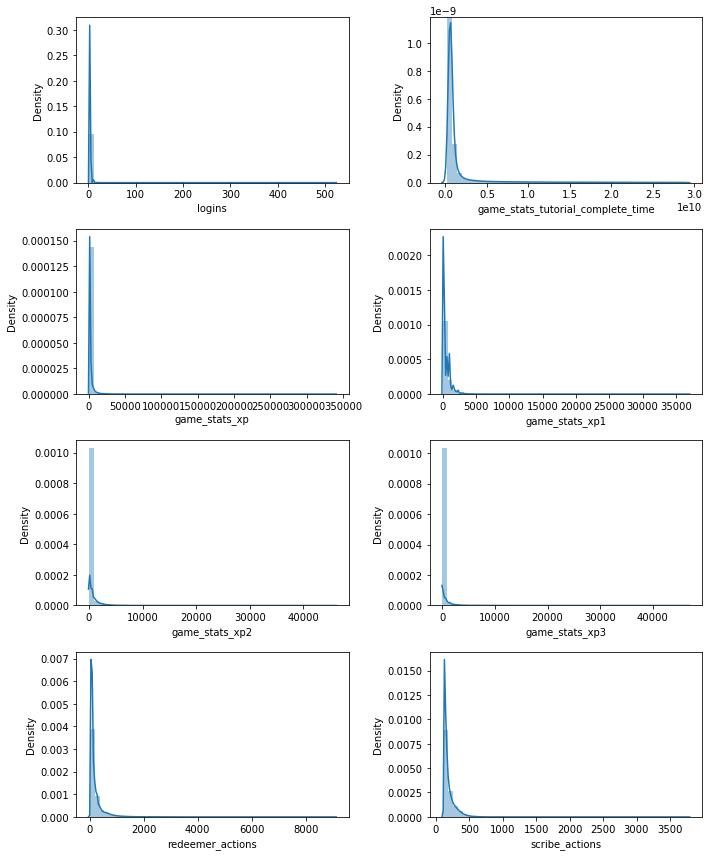

In [228]:
dfdisplot(final_df, action_cols,3,5,2)

<a name="2-3-1"></a> 
#### 2.3.1 Outliers Removal for Better Visualization & Comparison

In [155]:
final_df.shape

(1751748, 30)

In [156]:
target_outlier_columns = action_cols

In [249]:
#Outlier removal function on multiple columns based on Z score (3 sd away from the mean value)
def outlier_removal(df, columns):

    #Author: Raymond Peng
    #Input: dataframe & columns involved in outlier removal(must be quantitative columns)
    ##Note input dataframe can't have null values on selected columns for this function
    #Output: a new dataframe without outlier rows based on the cols you would like to remove outliers
    
    outliner_row_index = []
    for column in columns:
        data_mean, data_std = df[column].mean(), df[column].std()
        cut_off = data_std * 3
        lower, upper = data_mean - cut_off, data_mean + cut_off
        
        for i in range(0,len(df[column])):
            if df[column][i] < lower or df[column][i] > upper:
                outliner_row_index.append(i)
    
    return df.loc[~df.index.isin(outliner_row_index)]

In [159]:
df_final_no_outliers = outlier_removal(final_df,target_outlier_columns)

In [160]:
df_final_no_outliers.shape

(1595148, 30)

In [161]:
len(df_final_no_outliers)/len(final_df)

0.9106035799669816

In [162]:
#df_final_no_outliers.to_csv('df_final_no_outliers_all_action_cols.csv',index = False)

In [97]:
#df_final_no_outliers = pd.read_csv('df_final_no_outliers_all_action_cols.csv')

<a name="2-4"></a> 
### 2.4 Comparison of Action Columns between Free & Paid User 

<a name="2-4-1"></a> 
#### 2.4.1 BarPlot Comparison of Action Columns between Free & Paid User 

In [163]:
def dfbarplot(df, label, cols, rowSize=3, colSize=3, nCol=3):
    if len(cols) % nCol == 0:
        nRow= len(cols)// nCol
    else:
        nRow= len(cols)// nCol + 1
    fig,axes = plt.subplots(nRow,nCol,figsize=(nCol*colSize, nRow*rowSize))
    axes = axes.flatten()
    for i, var_name in enumerate(cols):
        g = sns.barplot(x= label, y = var_name, data = df,ax= axes[i])
     
    fig.tight_layout()
    fig.show()

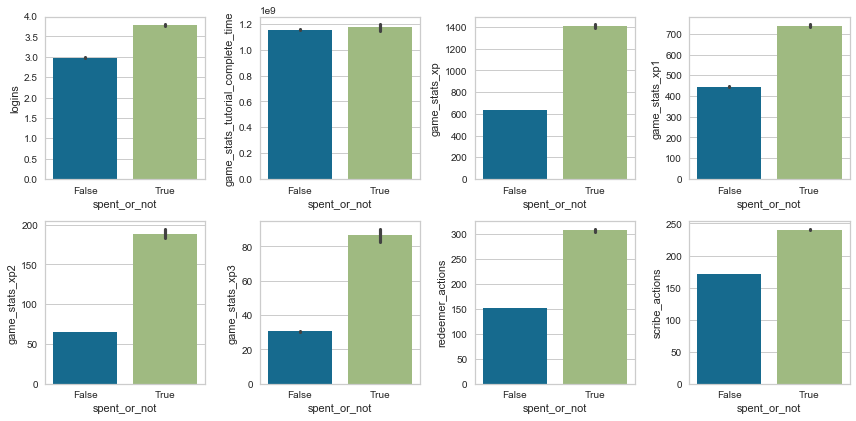

In [174]:
dfbarplot(df_final_no_outliers, 'spent_or_not', action_cols, rowSize=3, colSize=3, nCol=4)

<a name="2-4-2"></a> 
#### 2.4.2 BoxPlot Comparison of Action Columns between Free & Paid User

In [165]:
def dfboxplot(df, label, cols, rowSize=3, colSize=3, nCol=3):
    if len(cols) % nCol == 0:
        nRow= len(cols)// nCol
    else:
        nRow= len(cols)// nCol + 1
    fig,axes = plt.subplots(nRow,nCol,figsize=(nCol*colSize, nRow*rowSize))
    axes = axes.flatten()
    for i, var_name in enumerate(cols):
        g = sns.boxplot(x= label, y = var_name, data = df,ax= axes[i])
     
    fig.tight_layout()
    fig.show()

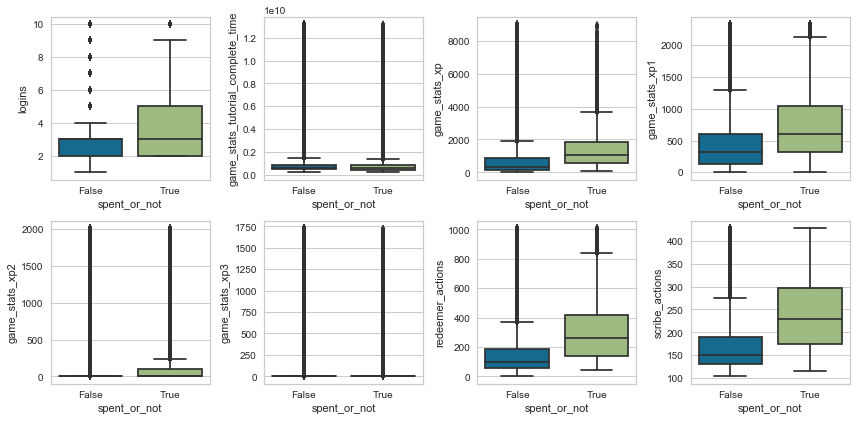

In [175]:
dfboxplot(df_final_no_outliers, 'spent_or_not', action_cols, rowSize=3, colSize=3, nCol=4)

<a name="2-4-3"></a> 
#### 2.4.3 Statistics Tests of Action Columns between Free & Paid User
- Figure out if the difference between free & paid users are significant under the action variables
- Apply 2 sample T test for means on action related columns

In [167]:
from scipy import stats

In [168]:
def two_tail_t_test_on_mean(df, category, columns):
    
    #Author: Raymond Peng
    #Input
        #df: The dataframe you want to do two tail t test on
        #category: The column that identify labels for two groups
        #columns: A list of features you want to do t test on (Should be continuous variables)
    #Output
        #String: Indicate whether the difference between two groups is significant
        #Note: Apply only when n1 > 20 and n2 > 20 to make sure sample sizes are large
        
    for column in columns:
    
        se1 = df.groupby([category])[column].std()[0]
        se2 = df.groupby([category])[column].std()[1]

        n1 = df[category].value_counts()[0]
        n2 = df[category].value_counts()[1]

        mean1 = df.groupby([category])[column].mean()[0]
        mean2 = df.groupby([category])[column].mean()[1]
        
        se = (se1**2/n1 + se2**2/n2)**0.5
        tstat = (mean1 - mean2)/se
        dof = (se1**2/n1 + se2**2/n2)**2/(1/(n1-1)*(se1**2/n1)**2+1/(n2-1)*(se2**2/n2)**2)
        
        if abs(tstat) > stats.t.ppf(1-0.025, dof):
            print(str(column)+' mean between ' + category + ' classes '+ \
                  str(df[category].value_counts().index[0])+' and ' +\
                  str(df[category].value_counts().index[1]) + "\033[1m" + ' is significant' + "\033[0m"+\
                  ', p-value: ' +str(stats.t.sf(np.abs(tstat), dof)*2))
        else:  
             print(str(column)+' mean between ' + category + ' classes '+ \
                  str(df[category].value_counts().index[0])+' and ' +\
                  str(df[category].value_counts().index[1]) + "\033[1m" + ' is not significant' + "\033[0m"+\
                  ', p-value: ' +str(stats.t.sf(np.abs(tstat), dof)*2))

In [169]:
two_tail_t_test_on_mean(df_final_no_outliers,'spent_or_not', action_cols)

logins mean between spent_or_not classes False and True is significant, p-value: 0.0
game_stats_tutorial_complete_time mean between spent_or_not classes False and True is not significant, p-value: 0.1846737739777683
game_stats_xp mean between spent_or_not classes False and True is significant, p-value: 0.0
game_stats_xp1 mean between spent_or_not classes False and True is significant, p-value: 0.0
game_stats_xp2 mean between spent_or_not classes False and True is significant, p-value: 0.0
game_stats_xp3 mean between spent_or_not classes False and True is significant, p-value: 1.0143056951621733e-183
redeemer_actions mean between spent_or_not classes False and True is significant, p-value: 0.0
scribe_actions mean between spent_or_not classes False and True is significant, p-value: 0.0


<a name="2-5"></a> 
### 2.5 Explore relationship between total spend per user and action columns with scatter plot

In [170]:
def dfscatterplot(df, label, cols, rowSize=3, colSize=3, nCol=3):
    if len(cols) % nCol == 0:
        nRow= len(cols)// nCol
    else:
        nRow= len(cols)// nCol + 1
    fig,axes = plt.subplots(nRow,nCol,figsize=(nCol*colSize, nRow*rowSize))
    axes = axes.flatten()
    for i, var_name in enumerate(cols):
        g = sns.scatterplot(x=var_name,y=label,data=df,ax= axes[i]);
     
    fig.tight_layout()
    fig.show()

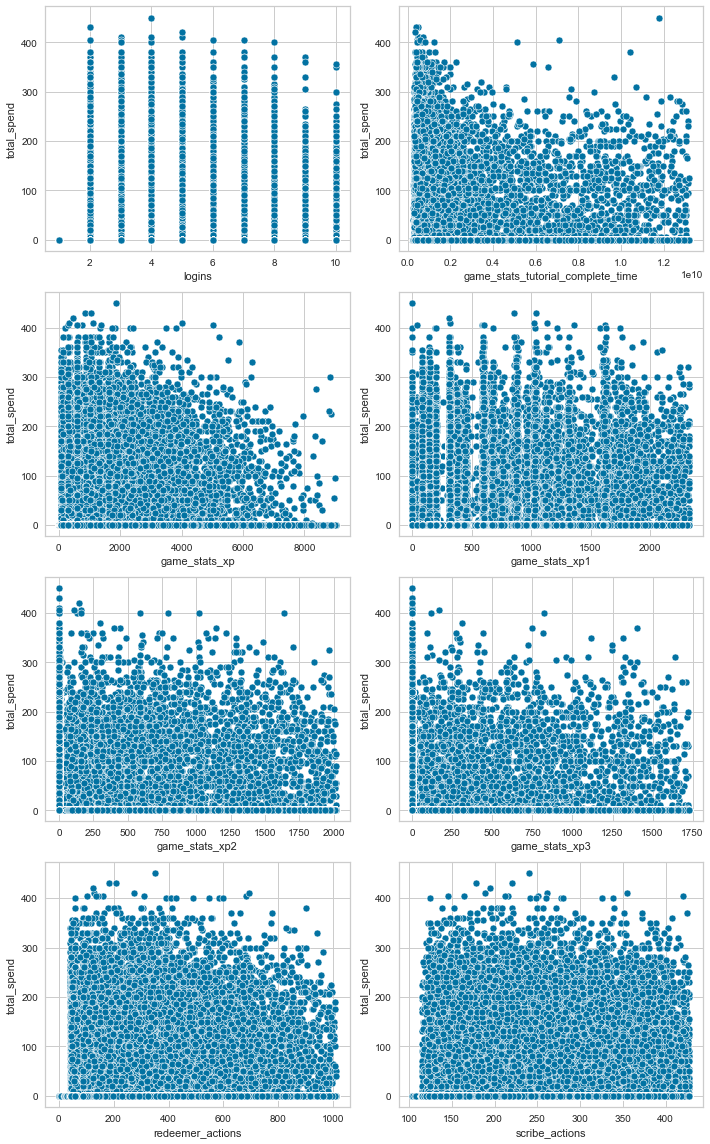

In [176]:
dfscatterplot(df_final_no_outliers,'total_spend',action_cols, rowSize=4, colSize=5, nCol=2)

In [329]:
#sns.scatterplot(x='game_stats_xp3',y='total_spend',data=df_final_no_outliers,)

<a name="2-6"></a> 
### 2.6 Correlation Exploration

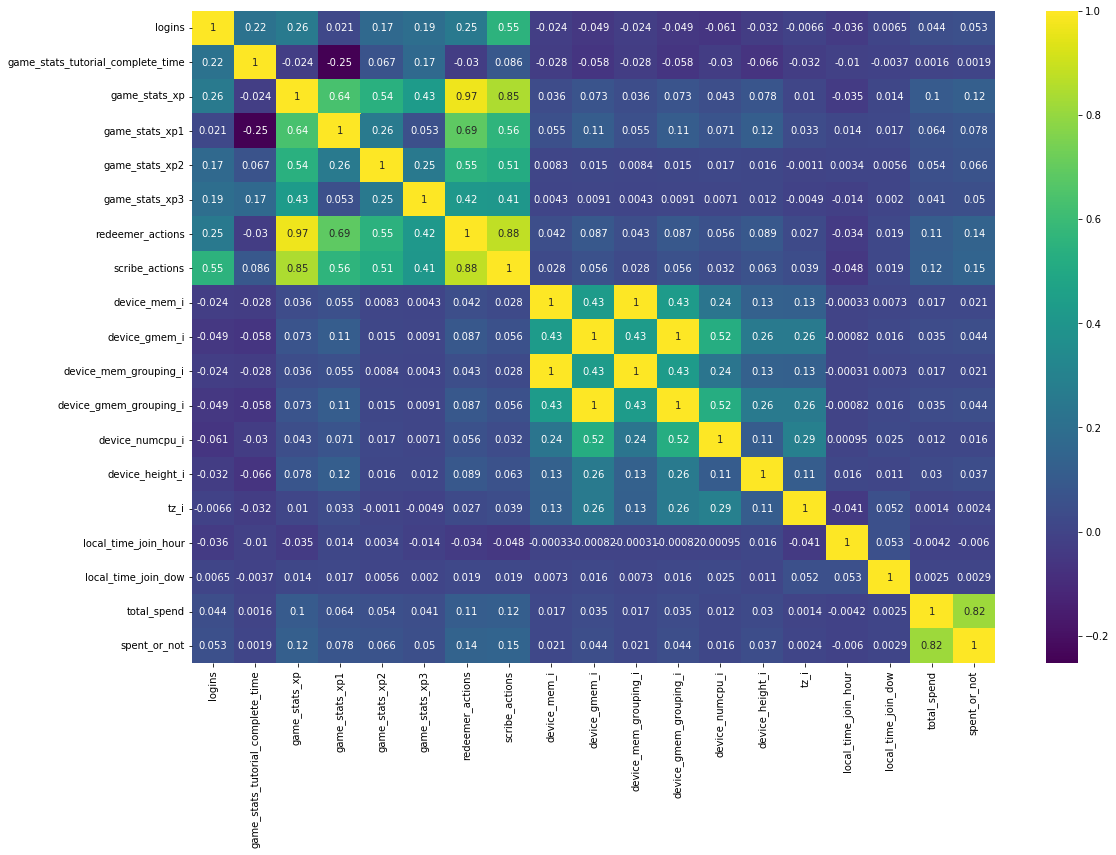

In [338]:
plt.figure(figsize=(18,12))
sns.heatmap(df_final_no_outliers.drop(['uid_s','game_stats_tutorial_complete'],axis = 1).corr(),annot=True,cmap='viridis')

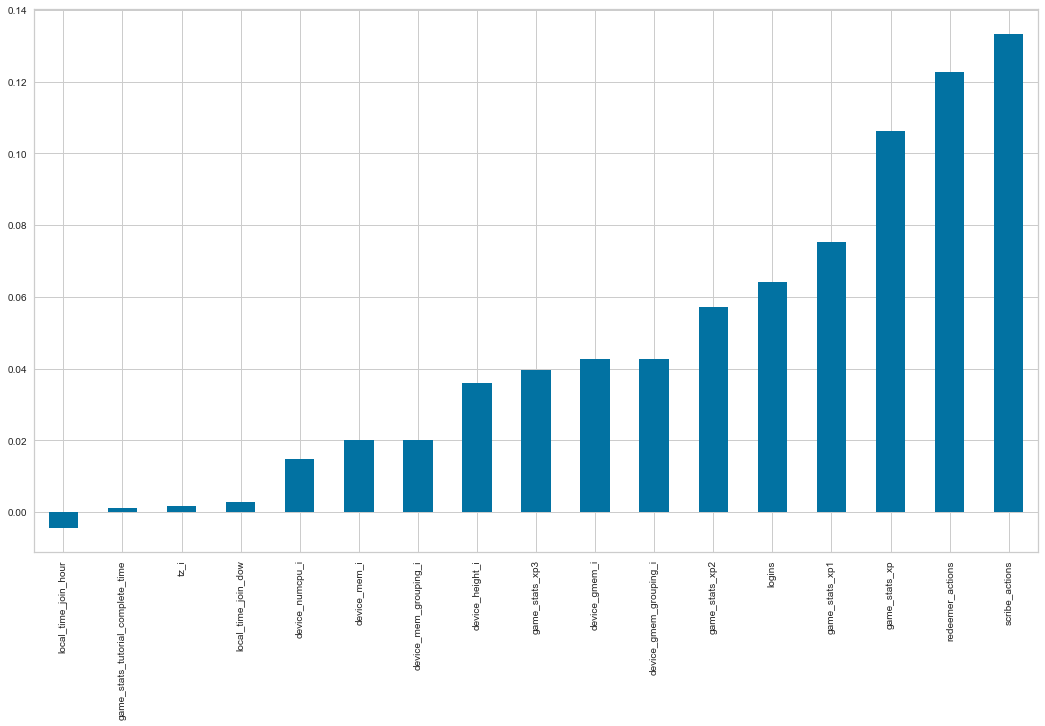

In [102]:
#Correlation with whether a user will spend or not
df_final_no_outliers.corr()['spent_or_not'].sort_values().drop(['spent_or_not','total_spend','uid_s','game_stats_tutorial_complete']).plot(kind='bar',figsize=(18,10))

<a name="3"></a> 
## 3. Classification Model for Paid User Identification
⏪ [Click here to go back to table of context](#0)

- Use known variable at the completion of tutorial to predict whether a new user will spend in the future

<a name="3-1"></a> 
### 3.1 Splitting the data

In [3]:
#final_df = pd.read_csv(r"C:\Users\penpe\Desktop\Kabam\kabam_ds_interview\df_final.csv")

In [104]:
import pandas as pd

In [109]:
final_df.columns

Index(['uid_s', 'logins', 'game_stats_tutorial_complete',
       'game_stats_tutorial_complete_time', 'game_stats_xp', 'game_stats_xp1',
       'game_stats_xp2', 'game_stats_xp3', 'redeemer_actions',
       'scribe_actions', 'platform_s', 'device_mapped_s',
       'device_manufacturer_s', 'device_mem_i', 'device_gmem_i',
       'device_mem_grouping_i', 'device_gmem_grouping_i', 'device_numcpu_i',
       'device_height_i', 'device_gpu_s', 'device_os_s', 'device_model_s',
       'lang_s', 'geo_s', 'region_s', 'tz_i', 'local_time_join_hour',
       'local_time_join_dow', 'total_spend', 'spent_or_not'],
      dtype='object')

In [110]:
#Select the known variables at the end of tutorial as features
X = final_df[[
       'game_stats_tutorial_complete_time', 'game_stats_xp', 'game_stats_xp1',
       'game_stats_xp2', 'game_stats_xp3', 
       'platform_s', 
       'device_mem_i', 'device_gmem_i',
       'device_mem_grouping_i', 'device_gmem_grouping_i', 'device_numcpu_i',
       'device_height_i', 'region_s', 'tz_i', 'local_time_join_hour',
       'local_time_join_dow']]

y = final_df['spent_or_not']

In [111]:
X.head()

,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,platform_s,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_height_i,region_s,tz_i,local_time_join_hour,local_time_join_dow
0,4.700000e+08,1693.0,592.0,0.0,429.0,android,3575.0,1024.0,3584.0,1024.0,8.0,720.0,asia,28800,14,3
1,6.120000e+08,197.0,197.0,0.0,0.0,android,1867.0,512.0,1920.0,512.0,8.0,1080.0,americas,-18000,14,1
2,3.900000e+08,313.0,313.0,0.0,0.0,android,3726.0,1024.0,3776.0,1024.0,8.0,1080.0,asia,28800,2,3
3,6.610000e+08,1319.0,1319.0,0.0,0.0,android,3629.0,1024.0,3648.0,1024.0,8.0,1080.0,asia,28800,8,6
4,3.147000e+09,148.0,148.0,0.0,0.0,android,2816.0,1024.0,2816.0,1024.0,8.0,720.0,asia,19800,19,6


In [112]:
from sklearn.model_selection import train_test_split

In [113]:
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)

In [114]:
y_train.value_counts()[1]/y_train.value_counts()[0]

0.017840619062196743

In [115]:
y_test.value_counts()[1]/y_test.value_counts()[0]

0.01781825032528871

In [116]:
y_test.value_counts()

False    567957
True      10120
Name: spent_or_not, dtype: int64

In [117]:
train = X_train.copy()
train['spent_or_not'] = y_train

test = X_test.copy()
test['spent_or_not'] = y_test

In [118]:
test.shape

(578077, 17)

In [119]:
y.isnull().sum()

0

<a name="3-2"></a> 
### 3.2 Paid User Classification Model - Training & Evaluation

In [120]:
from pycaret.classification import *

In [121]:
#train.isnull().sum()

In [123]:
classification_setup = setup(train, target = 'spent_or_not'
                             ,fix_imbalance = True 
                             #,fix_imbalance_method = 'SMOTE' (default)
                             ,remove_outliers = True
                             ,numeric_features = ['device_gmem_i','device_gmem_grouping_i','device_numcpu_i']
                             ,categorical_features = ['local_time_join_hour']
                             ,outliers_threshold = 0.05
                             #,remove_multicollinearity = True
                             ,normalize = True
                             ,test_data = test
                             #,feature_selection = True
                             ,session_id=123)

,Description,Value
0,session_id,123
1,Target,spent_or_not
2,Target Type,Binary
3,Label Encoded,"False: 0, True: 1"
4,Original Data,"(1173671, 17)"
5,Missing Values,True
6,Numeric Features,12
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [124]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9778,0.7555,0.0189,0.0438,0.0264,0.017,0.0185,162.9
lightgbm,Light Gradient Boosting Machine,0.9593,0.7947,0.1472,0.0795,0.1032,0.0843,0.0885,11.85
dt,Decision Tree Classifier,0.9475,0.5328,0.1044,0.0419,0.0596,0.0378,0.042,13.93
knn,K Neighbors Classifier,0.9087,0.6271,0.2662,0.0505,0.085,0.0598,0.0837,609.6
nb,Naive Bayes,0.8331,0.7381,0.4962,0.0474,0.0865,0.0592,0.1125,3.604
gbc,Gradient Boosting Classifier,0.8308,0.8014,0.5798,0.0538,0.0984,0.0713,0.1376,240.9
ada,Ada Boost Classifier,0.7861,0.7906,0.6415,0.0468,0.0872,0.0593,0.1303,47.49
svm,SVM - Linear Kernel,0.7701,0,0.6606,0.0448,0.0839,0.0557,0.1277,4.666
lr,Logistic Regression,0.7622,0.7935,0.6713,0.0439,0.0825,0.0542,0.1269,11.7
ridge,Ridge Classifier,0.7605,0,0.6558,0.0427,0.0802,0.0519,0.1217,4.59


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

<b>Conclusion:</b>
Based on the comparison above after doing 10 fold CV on the training dataset, Logistic Regression Model gives us a great Recall ratio while maintaining a good accuracy. It will be the model of choice compared to other ML models

In [125]:
#Based on the model performance & the business case here, we will be using the logistics regression model
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7621,0.7959,0.6721,0.044,0.0825,0.0543,0.1271
1,0.762,0.8002,0.6734,0.0441,0.0827,0.0544,0.1274
2,0.7633,0.7931,0.6712,0.0442,0.0829,0.0546,0.1274
3,0.7616,0.7952,0.6695,0.0437,0.0821,0.0538,0.1261
4,0.7627,0.7927,0.6717,0.0441,0.0827,0.0544,0.1273
5,0.7612,0.7985,0.6774,0.0441,0.0829,0.0546,0.1282
6,0.7607,0.7967,0.6852,0.0445,0.0836,0.0553,0.1301
7,0.761,0.7918,0.667,0.0435,0.0816,0.0533,0.1251
8,0.7627,0.7859,0.6569,0.0432,0.081,0.0527,0.1231
9,0.7648,0.7851,0.6687,0.0443,0.083,0.0548,0.1274


In [126]:
print(lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


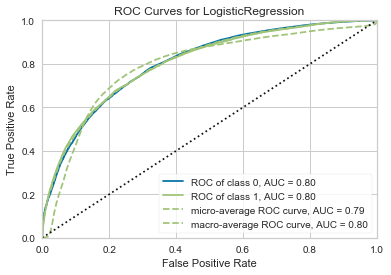

In [127]:
#ROC AUC Curves
plot_model(lr, plot = 'auc')

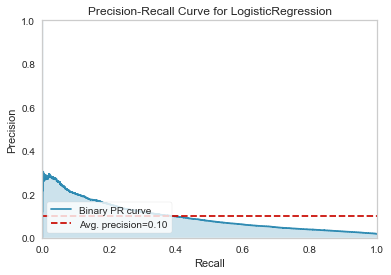

In [128]:
#Plot Recall vs Prevision Curve
plot_model(lr, plot = 'pr')

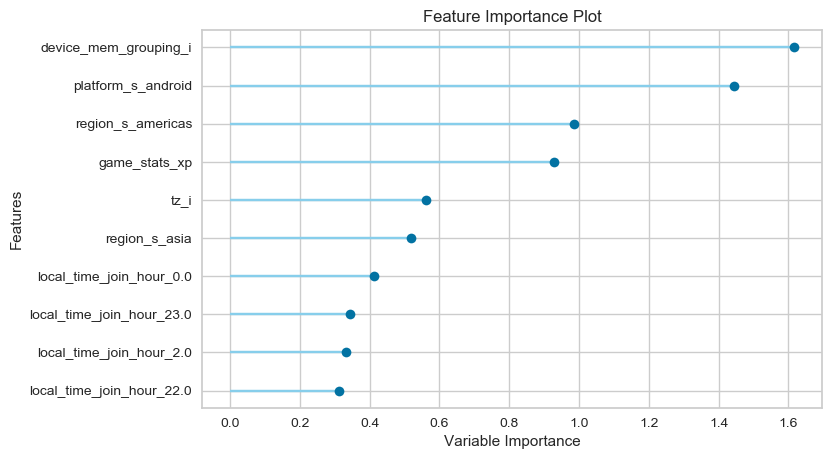

In [129]:
#Features below are selected using a combination of various permutation importance techniques 
#including Random Forest, Adaboost and Linear correlation with target variable
plot_model(lr, plot='feature')

In [130]:
#Predict on the test data
predict_model(lr);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7496,0.8049,0.7032,0.0478,0.0895,0.0587,0.1361


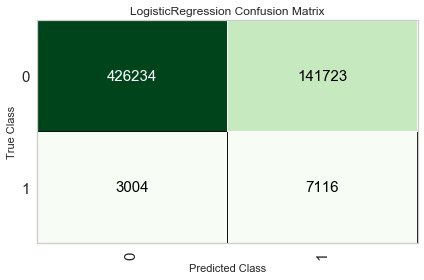

In [131]:
#interpret_model(ridge, plot = 'correlation')
#!pip install shap
plot_model(lr, plot = 'confusion_matrix')
#Able to identify 70% of the potential paid user in the test set

In [132]:
# Fit the model to the whole train & test set, save it as a sklearn model object
final_lr = finalize_model(lr)
print(final_lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


<a name="3-3"></a> 
### 3.3 Save paid user identification model for future deployment

In [133]:
save_model(final_lr,'Final Logistic Regression Model for Identifying Paid Users after Tutorial')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['local_time_join_hour'],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['device_gmem_i',
                                                           'device_gmem_grouping_i',
                                                           'device_numcpu_i'],
                                       target='spent_or_not',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strate...
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                 ('dfs', 'passthrough'), ('pca', 'passthrough'),
                 ['trained_model',
                  LogisticRegressio

In [134]:
#Load model
saved_final_lr = load_model('Final Logistic Regression Model for Identifying Paid Users after Tutorial')

Transformation Pipeline and Model Successfully Loaded


In [135]:
#Test the prediction
new_prediction = predict_model(saved_final_lr, data=test.iloc[-5:,:])

In [136]:
new_prediction.head()

,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,platform_s,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_height_i,region_s,tz_i,local_time_join_hour,local_time_join_dow,spent_or_not,Label,Score
600107,8.940000e+08,312.0,312.0,0.0,0.0,android,960.0,256.0,960.0,256.0,4.0,480.0,americas,0,15,1,False,False,0.8140
737944,5.600000e+08,138.0,138.0,0.0,0.0,android,3595.0,1024.0,3648.0,1024.0,8.0,1080.0,asia,28800,3,3,False,False,0.6763
440760,8.260000e+08,80.0,80.0,0.0,0.0,android,3578.0,1024.0,3584.0,1024.0,8.0,720.0,asia,28800,7,1,False,False,0.7208
669327,5.870000e+08,376.0,376.0,0.0,0.0,android,7477.0,2048.0,7488.0,2048.0,8.0,1080.0,asia,28800,12,2,False,True,0.6538
1564215,2.754000e+09,1846.0,308.0,293.0,1245.0,android,1360.0,512.0,1408.0,512.0,4.0,720.0,europe,7200,17,2,False,False,0.8248


<a name="4"></a> 
## 4. Cluster Model to Segment Paid Users based on Engagement Level (XP Collected)
⏪ [Click here to go back to table of context](#0)

In [5]:
final_df_spender = final_df[final_df['spent_or_not']==1]

In [6]:
final_df_spender.shape

(30692, 30)

In [7]:
final_df_spender.head()

,uid_s,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions,...,device_os_s,device_model_s,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow,total_spend,spent_or_not
10,13,3.0,1.0,494000000.0,1023.0,306.0,0.0,0.0,254.0,228.0,...,android os 8.1.0 / api-27 (opm1.171019.026/155...,16th,ZH-CN,CN,asia,28800,11,6,70,True
91,160,4.0,1.0,458000000.0,2345.0,2345.0,0.0,0.0,480.0,220.0,...,ios 12.2,"iphone10,6",EN,US,americas,-18000,15,5,140,True
103,181,5.0,1.0,310000000.0,1040.0,1040.0,0.0,0.0,285.0,231.0,...,ios 12.1.4,"iphone11,2",JA,JP,asia,32400,5,6,160,True
123,214,5.0,1.0,535000000.0,14557.0,599.0,0.0,0.0,1315.0,383.0,...,ios 12.2,"iphone11,2",EN,US,americas,-14400,16,5,70,True
318,551,4.0,1.0,326000000.0,80.0,80.0,0.0,0.0,42.0,143.0,...,ios 12.2,"iphone10,2",EN,US,americas,-18000,15,5,40,True


(0, 500)

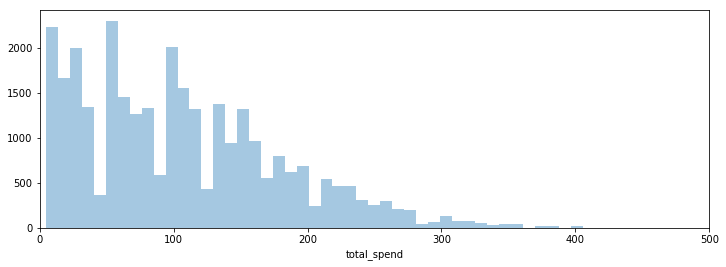

In [19]:
plt.figure(figsize=(12,4))
sns.distplot(final_df_spender['total_spend'],kde=False,bins=50)
plt.xlim(0,500)

<a name="4-1"></a> 
### 4.1 Unsupervised Clustering - Model Training & Evaluation

In [149]:
#final_df_spender.columns

In [69]:
spender_df_for_clustering = final_df_spender[[
       'game_stats_xp','game_stats_xp1',
       'game_stats_xp2', 'game_stats_xp3']]

In [70]:
spender_df_for_clustering.head()

,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3
10,1023.0,306.0,0.0,0.0
91,2345.0,2345.0,0.0,0.0
103,1040.0,1040.0,0.0,0.0
123,14557.0,599.0,0.0,0.0
318,80.0,80.0,0.0,0.0


In [71]:
from pycaret.clustering import *

In [72]:
exp_clu = setup(spender_df_for_clustering, normalize = True,
                   #numeric_features = [''],   
                   #pca = True,
                   #pca_components = 0.99,
                   #ignore_features = ['total_spend'],
                   normalize_method = 'robust', #Robus method works well for data with outliers
                   session_id = 123)

,Description,Value
0,session_id,123
1,Original Data,"(30692, 4)"
2,Missing Values,False
3,Numeric Features,4
4,Categorical Features,0
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(30692, 4)"
9,CPU Jobs,-1


In [73]:
#Number of clusters is selected based on the Elbow method presented below
kmeans = create_model('kmeans',num_clusters=4)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7167,54490.7108,0.6756,0,0,0


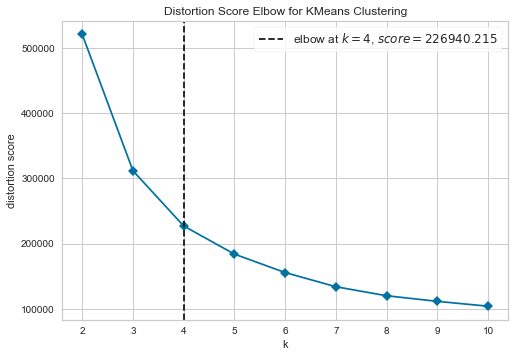

In [29]:
#Select number of clusters with elbow method
plot_model(kmeans, plot = 'elbow')

<a name="4-2"></a> 
### 4.2 Visualize Clusters with PCA & TSNE
- To make sure those clusters look distinct enough from each other

In [3]:
#2D Cluster PCA Plot
plot_model(kmeans)

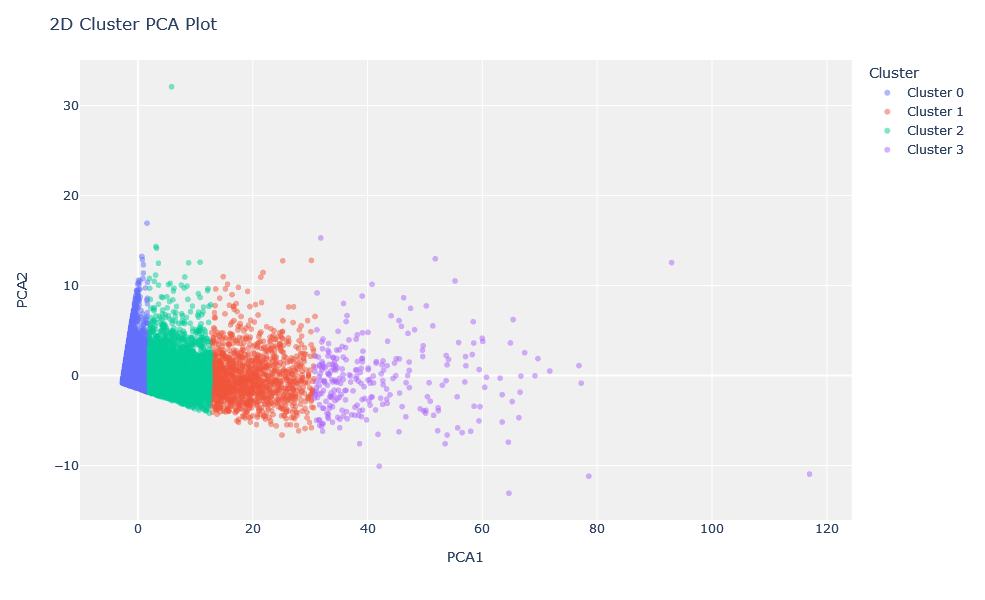

In [4]:
#3D TSNE Plot
plot_model(kmeans, plot ='tsne')

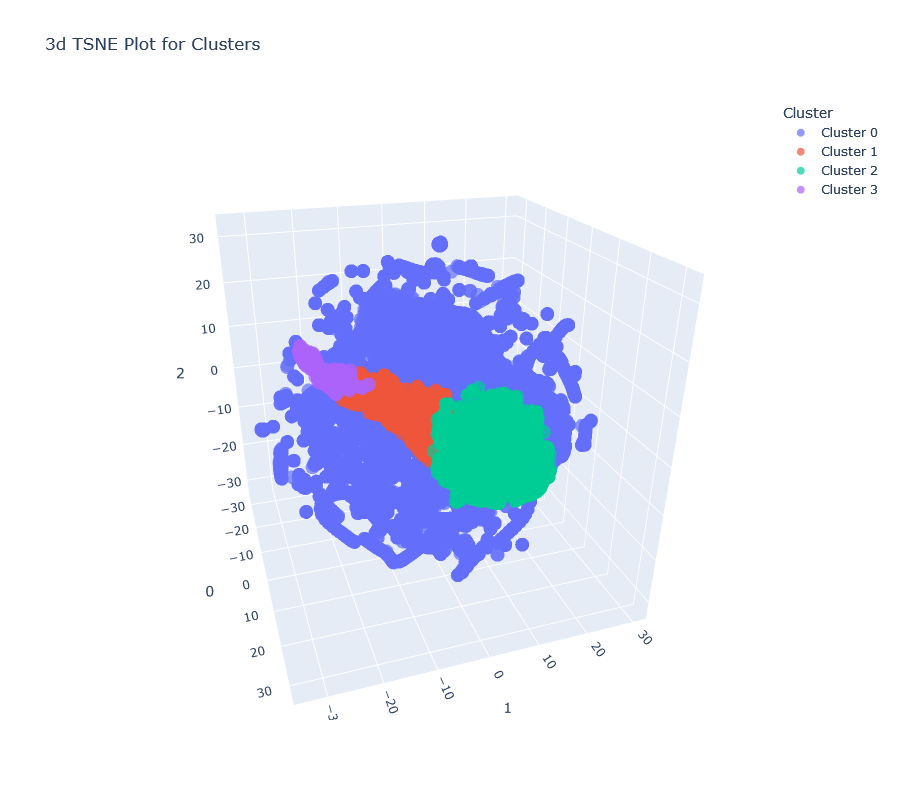

In [74]:
print(kmeans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=123, tol=0.0001, verbose=0)


In [75]:
#Assign cluster label to the original dataset
kmean_results = assign_model(kmeans)
kmean_results.head()

,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,Cluster
10,1023.0,306.0,0.0,0.0,Cluster 0
91,2345.0,2345.0,0.0,0.0,Cluster 0
103,1040.0,1040.0,0.0,0.0,Cluster 0
123,14557.0,599.0,0.0,0.0,Cluster 0
318,80.0,80.0,0.0,0.0,Cluster 0


In [76]:
kmean_results.Cluster.value_counts()

Cluster 0    25841
Cluster 2     3284
Cluster 1     1299
Cluster 3      268
Name: Cluster, dtype: int64

In [2]:
#Explore distribution on one of the features on each cluster
plot_model(kmeans, plot = 'distribution', feature = 'game_stats_xp')

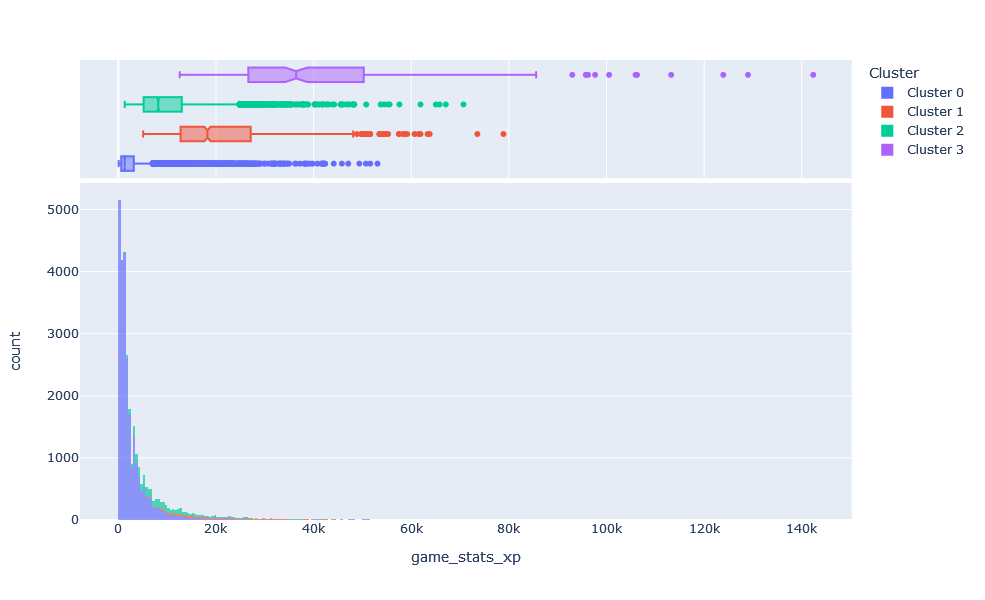

<a name="4-3"></a> 
### 4.3 Compare exp_stats features between clusters

In [78]:
df_means = pd.DataFrame([])

kmean_results['Cluster'] = kmean_results['Cluster'].apply(lambda x: int(x[-1]))

kmean_results_numeric = kmean_results

In [79]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(kmean_results_numeric)
kmean_results_numeric = pd.DataFrame(scaler.transform(kmean_results_numeric),columns = kmean_results_numeric.columns)

In [80]:
kmean_results_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30692 entries, 0 to 30691
Data columns (total 5 columns):
game_stats_xp     30692 non-null float64
game_stats_xp1    30692 non-null float64
game_stats_xp2    30692 non-null float64
game_stats_xp3    30692 non-null float64
Cluster           30692 non-null float64
dtypes: float64(5)
memory usage: 1.2 MB


In [81]:
cols = kmean_results_numeric.columns
for i in cols:
    df_means[i] = kmean_results_numeric.groupby('Cluster')[i].mean()

df_means = df_means.drop(['Cluster'], axis=1)

In [82]:
df_means #need to fix the cluster number on the group by object

,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3
Cluster,,,,
0.000000,0.017753,0.087332,0.014863,0.002453
0.333333,0.150498,0.185617,0.114953,0.178899
0.666667,0.073510,0.123325,0.057867,0.070358
1.000000,0.289728,0.288131,0.225748,0.369402


In [83]:
df_means['Cluster'] = [0,1,2,3]
df_means.set_index(['Cluster'],drop = True,inplace = True)
df_means.head()

,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3
Cluster,,,,
0,0.017753,0.087332,0.014863,0.002453
1,0.150498,0.185617,0.114953,0.178899
2,0.073510,0.123325,0.057867,0.070358
3,0.289728,0.288131,0.225748,0.369402


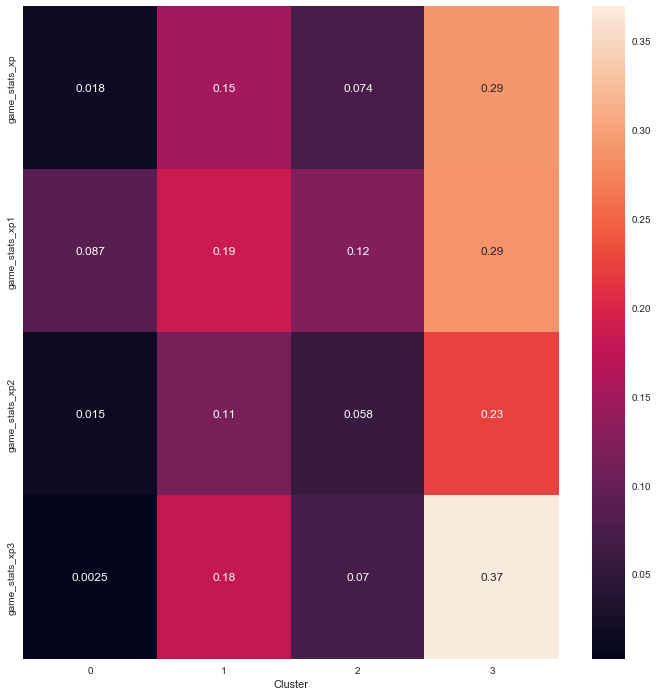

In [84]:
fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(df_means.T, annot = True)
plt.show()

##### Insights & Takeaways
- We can see the exp levels collected on different tutorial phrases are ranked by cluster3/1/2/0 from high to low
- Based on the previous assumptions, paid players belong to cluster 3 earned the high exp points during tutorial reflecting high engagement level, while paid players belong to cluster 0 earned the low exp points during tutorial reflecting high engagement level
- Game designer can use the characteristics of each cluster label to decide what customized prices and offers to give

<a name="4-4"></a> 
### 4.4 Save segmentation model for deployment & predict cluster label for future new users

In [85]:
save_model(kmeans,'Final Kmeans Segmentation Model for Spent User')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='UNSUPERVISED_DUMMY_TARGET',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='most frequent',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None...
                 ('fix_perfect', 'passthrough'),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                 ('dfs', 'passthrough'), ('pca', 'passthrough'),
                 ['trained_model',
                  KMe

In [86]:
#Test loading saved model
saved_kmeans = load_model('Final Kmeans Segmentation Model for Spent User')

Transformation Pipeline and Model Successfully Loaded


In [103]:
#Use loaded model to predict on new data
new_prediction = predict_model(saved_kmeans, data=spender_df_for_clustering.iloc[-5:,])

In [88]:
new_prediction

,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,Cluster
1751355,12578.0,1309.0,3450.0,7683.0,Cluster 1
1751361,5388.0,604.0,0.0,0.0,Cluster 0
1751531,54777.0,3578.0,0.0,10886.0,Cluster 3
1751558,18674.0,850.0,2259.0,0.0,Cluster 0
1751624,2364.0,458.0,1167.0,264.0,Cluster 0
